In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import cv2


cudnn.benchmark = True
plt.ion()

In [ ]:
!unzip data.zip
%ls

Archive:  data.zip
replace data/normal/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataset_dir, train=False):
        self.data_transforms = {
                            'train': transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
                            'val': transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
                        }
        self.dataset_dir = dataset_dir

        self.labels = []
        self.raw_images = []
        self.train = train

        for dirpath, dirnames, filenames in os.walk(dataset_dir):
            for fn in filenames:
                label = 0 if 'normal' in dirpath else 1
                raw_img = cv2.imread(f'{dirpath}/{fn}')
                self.labels.append(label)
                self.raw_images.append(raw_img)

        self.train_images = [self.data_transforms['train'](img) for img in self.raw_images]
        self.test_images = [self.data_transforms['val'](img) for img in self.raw_images]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.train:
            return self.train_images[idx], self.labels[idx]
        else:
            return self.test_images[idx], self.labels[idx]

In [ ]:
data_dir = '/content/data'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
n_images = 0
for dirpath, dirnames, filenames in os.walk(data_dir):
    n_images += len(filenames)

In [ ]:
n_images

In [ ]:
image_idxs = np.arange(n_images)

In [ ]:
from torch.utils.data import Dataset, DataLoader, Sampler, Subset, random_split

dataset = ImageDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=47)

In [ ]:
class_names = {0: 'normal', 1: 'phishing'}

In [ ]:
def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_losses_by_folds = [np.zeros(n_folds) for i in range(num_epochs)]
    val_losses_by_folds = [np.zeros(n_folds) for i in range(num_epochs)]
    train_accs_by_folds = [np.zeros(n_folds) for i in range(num_epochs)]
    val_accs_by_folds = [np.zeros(n_folds) for i in range(num_epochs)]

    best_model_params_path = os.path.join('.', 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for i, (train_index, test_index) in enumerate(skf.split(dataset.raw_images, dataset.labels)):
            test_loader = DataLoader(dataset, batch_size=8, sampler=test_index)
            train_loader = DataLoader(dataset, batch_size=8, sampler=train_index)

            print(f'\tFold: {i}/{n_folds}')
            print('\t' + '-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    loader = train_loader
                    model.train()
                else:
                    loader = test_loader
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()
                    fold_train_loss = running_loss / len(train_index)
                    fold_train_acc = running_corrects.double() / len(train_index)
                    train_losses_by_folds[epoch][i] = fold_train_loss
                    train_accs_by_folds[epoch][i] = fold_train_acc
                    print(f'\t\ttrain loss: {fold_train_loss}')
                    print(f'\t\ttrain acc: {fold_train_acc}')
                else:
                    fold_val_loss = running_loss / len(test_index)
                    fold_val_acc = running_corrects.double() / len(test_index)
                    val_losses_by_folds[epoch][i] = fold_val_loss
                    val_accs_by_folds[epoch][i] = fold_val_acc
                    print(f'\t\tval loss: {fold_val_loss}')
                    print(f'\t\tval acc: {fold_val_acc}')
                print()

            if val_accs_by_folds[epoch].mean() > best_acc:
                best_acc = val_accs_by_folds[epoch].mean()
                torch.save(model.state_dict(), best_model_params_path)
    print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best mean val Acc: {best_acc:4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    train_losses_by_folds = np.array(train_losses_by_folds)
    val_losses_by_folds = np.array(val_losses_by_folds)
    train_accs_by_folds = np.array(train_accs_by_folds)
    val_accs_by_folds = np.array(val_accs_by_folds)


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses_by_folds.mean(axis=1), label='Training Loss')
    plt.plot(val_losses_by_folds.mean(axis=1), label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs_by_folds.mean(axis=1), label='Training Accuracy')
    plt.plot(val_accs_by_folds.mean(axis=1), label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet152(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch: 0/49
----------
	Fold: 0/5
	----------
		train loss: 0.5811467140229409
		train acc: 0.8875000000000001

		val loss: 9.814721155166627
		val acc: 0.6875

	Fold: 1/5
	----------
		train loss: 7.500088932384915
		train acc: 0.4625

		val loss: 11.564286448219173
		val acc: 0.6875

	Fold: 2/5
	----------
		train loss: 3.5869400311261415
		train acc: 0.434375

		val loss: 1.2218249768018723
		val acc: 0.6875

	Fold: 3/5
	----------
		train loss: 0.948158517293632
		train acc: 0.625

		val loss: 1.0388277933001517
		val acc: 0.6875

	Fold: 4/5
	----------
		train loss: 0.9391337361186742
		train acc: 0.6468750000000001

		val loss: 0.801534503698349
		val acc: 0.6875

Epoch: 1/49
----------
	Fold: 0/5
	----------
		train loss: 0.7931342178955674
		train acc: 0.659375

		val loss: 0.7718688637018204
		val acc: 0.6875

	Fold: 1/5
	----------
		train loss: 0.8101993216201663
		train acc: 0.6468750000000001

		val loss: 0.9242387980222702
		val acc: 0.6875

	Fold: 2/5
	----------
		train

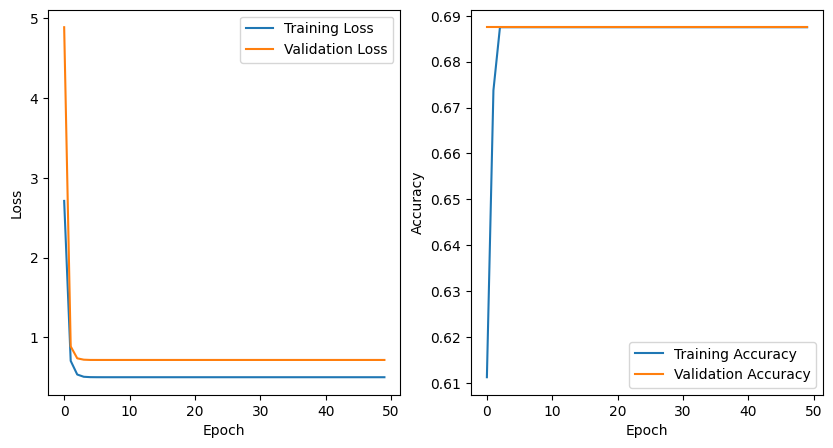

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

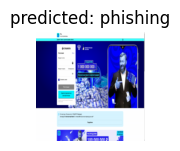

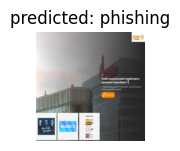

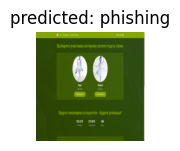

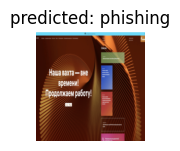

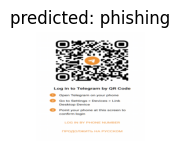

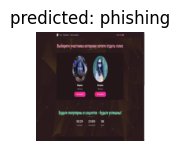

In [16]:
visualize_model(model_ft)

In [17]:
model_conv = torchvision.models.resnet152(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch: 0/49
----------
	Fold: 0/5
	----------
		train loss: 0.7320965396534239
		train acc: 0.878125

		val loss: 9.316778469085694
		val acc: 0.6875

	Fold: 1/5
	----------
		train loss: 8.707565951722492
		train acc: 0.484375

		val loss: 11.99512209892273
		val acc: 0.6875

	Fold: 2/5
	----------
		train loss: 10.878802819850275
		train acc: 0.41250000000000003

		val loss: 10.991697645187378
		val acc: 0.6875

	Fold: 3/5
	----------
		train loss: 10.111064378285949
		train acc: 0.44062500000000004

		val loss: 10.603437328338623
		val acc: 0.6875

	Fold: 4/5
	----------
		train loss: 10.254990932703002
		train acc: 0.4375

		val loss: 11.089546012878419
		val acc: 0.6875

Epoch: 1/49
----------
	Fold: 0/5
	----------
		train loss: 10.028963134088027
		train acc: 0.44375000000000003

		val loss: 11.269065570831298
		val acc: 0.6875

	Fold: 1/5
	----------
		train loss: 10.088024275811517
		train acc: 0.44062500000000004

		val loss: 10.83194670677185
		val acc: 0.6875

	Fold: 2/5
	-

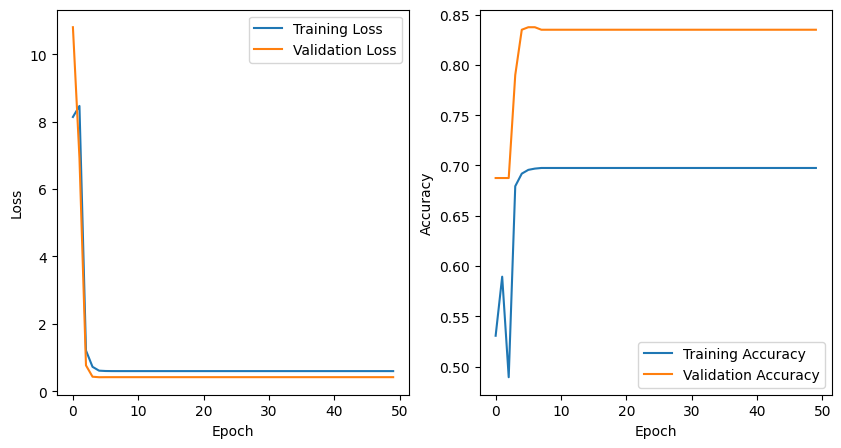

In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=50)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## ROC curve

100%|██████████| 50/50 [00:03<00:00, 13.08it/s]


Test Loss: 0.41933108627796173, Test Accuracy: 0.84


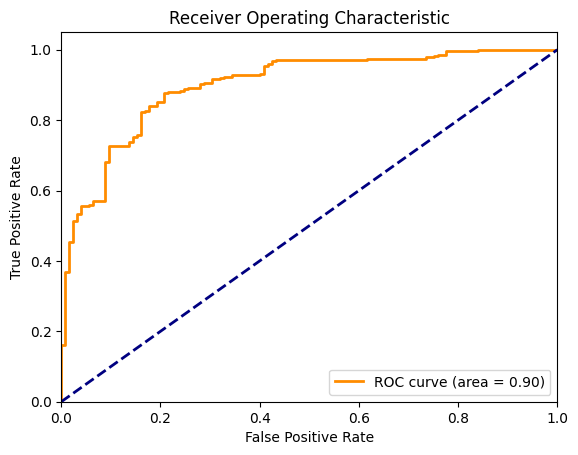

In [20]:
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

# Evaluate the model on the test set
test_loader = DataLoader(dataset, batch_size=8, shuffle=False)
model_conv.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_probs = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_conv(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(outputs.softmax(dim=1)[:, 1].cpu().numpy())  # Probability of class 1

test_loss /= len(test_loader)
test_accuracy = correct / total
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
